# Experiment TRIVIAL1 

Trivial case to give an intuition about true score and how it relates 
to human ratings: we show that as the number of raters increase, the mean H
approaches true score mean and the correlation 
with mean will approach the known correlation with true score. 
Yet the correlation against individual raters will vary. 

In [263]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

import json

In [264]:
config = json.load(open('settings.json'))
total_n_raters = sum(config['n_raters'])

In [265]:
df = pd.read_csv('../data/data.csv')
df_raters = pd.read_csv('../data/raters.csv')
df_systems = pd.read_csv('../data/systems.csv')

In [266]:
# compute the cumulative mean of human scores per category.
agg_list = []
diff_list = []
for category in df_raters['category'].unique():
    human_columns_category = df_raters[df_raters['category']==category]['rater_id']
    df_agg = df[human_columns_category].expanding(min_periods=1, axis=1).mean()
    df_agg.columns = ['N={}'.format(n) for n in range(1, len(human_columns_category)+1)]
    df_difference = df_agg.subtract(df['true'], axis=0)
    df_agg['category'] = category
    df_difference['category'] = category
    df_agg['id'] = df['id']
    agg_list.append(df_agg)
    diff_list.append(df_difference)

In [267]:
df_agg = pd.concat(agg_list)
df_diff = pd.concat(diff_list)

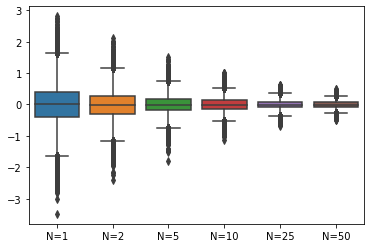

In [268]:
#Plot difference for key N raters: the plot shows that the scores get closer to true score as the 
# number of raters increases
sns.boxplot(data=df_diff[['N={}'.format(i) for i in config['key_steps_n_raters']]])

In [269]:
corr_true = df_agg.groupby('category').corrwith(df['true']).unstack().reset_index()
corr_true

,level_0,category,0
0,N=1,average,0.771849
1,N=1,high,0.892225
2,N=1,low,0.631270
3,N=1,moderate,0.736832
4,N=2,average,0.865274
...,...,...,...
195,N=49,moderate,0.991338
196,N=50,average,0.993200
197,N=50,high,0.993685
198,N=50,low,0.984513


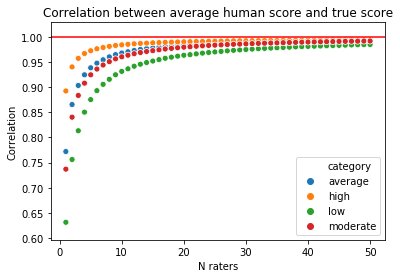

In [270]:
# correlation between human score and true score
corr_true = df_agg.groupby('category').corrwith(df['true']).unstack().reset_index()
corr_true.columns = ['N_raters', 'category', 'correlation']
corr_true['N'] = corr_true['N_raters'].apply(lambda x: int(x.split('=')[1]))
ax = sns.scatterplot(x='N', y='correlation', hue='category', data=corr_true)
ax.axhline(1, color='red')
ax.set_xlabel("N raters")
ax.set_ylabel("Correlation")
ax.set_title("Correlation between average human score and true score");

## Correlation with a sample system

In [271]:
# baseline: system correlation with true score. 
df['system'] = df[config['sample_system']]
exp_r2 = df_systems[df_systems['system_id'] == config['sample_system']]['exp_r2_true'].values[0]
true_corr = pearsonr(df['system'], df['true'])[0]
true_r2 = r2_score(df['true'], df['system'])
print("Expected system R2: {}\n"
      "system correlation with true score: {}\n"
      "system R2 with true score: {}".format(exp_r2, true_corr, true_r2))

Expected system R2: 0.8
system correlation with true score: 0.9124287935322448
system R2 with true score: 0.7998688213787986


In [272]:
# correlations with individual raters
human_columns = df_raters['rater_id']
corrs_raters = pd.DataFrame(df[human_columns].corrwith(df['system']))
corrs_raters.columns = ['corr']
# add category
df_corr_with_raters = pd.merge(corrs_raters, df_raters, left_index=True, right_on='rater_id')

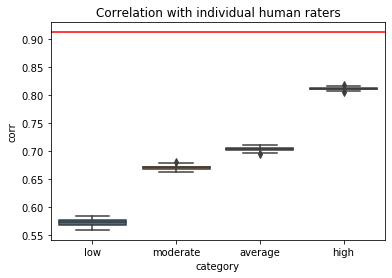

In [273]:
ax = sns.boxplot(x='category', y='corr', data=df_corr_with_raters)
ax.set_title("Correlation with individual human raters")
ax.axhline(true_corr, color='red')

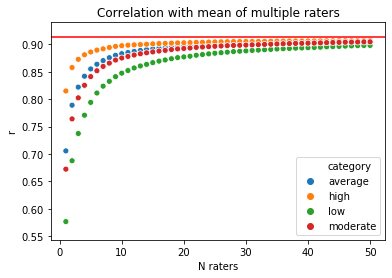

In [274]:
# compute correlations with aggregated scores
corr_mean = df_agg.groupby('category').corrwith(df['system']).unstack().reset_index()
corr_mean.columns = ['N_raters', 'category', 'correlation']
corr_mean['N'] = corr_true['N_raters'].apply(lambda x: int(x.split('=')[1]))
ax = sns.scatterplot(x='N', y='correlation', hue='category', data=corr_mean)
ax.axhline(true_corr, color='red')
ax.set_xlabel("N raters")
ax.set_ylabel("r")
ax.set_title("Correlation with mean of multiple raters");

## R2

We also consider R2, proportional reduction in MSE, because PRMSE is essentially this but against true scores. 

In [275]:
# baseline: system r2 with true score.
true_r2 = r2_score(df['true'], df['system'])
true_r2

0.7998688213787986

In [276]:
# r2 with individual raters
r2_raters = []
for h in human_columns:
    r2_raters.append(r2_score(df[h], df['system']))
r2_raters = pd.DataFrame({'rater_id': human_columns,
                          'r2': r2_raters})
# add category
df_r2_with_raters = pd.merge(r2_raters, df_raters)

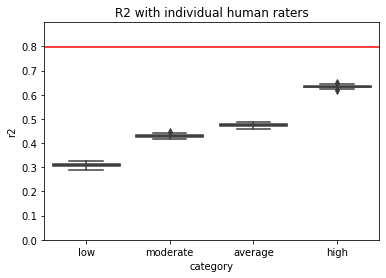

In [277]:
ax=sns.boxplot(x='category', y='r2', data=df_r2_with_raters)
ax.set_ylim(0, true_r2+0.1)
ax.set_title("R2 with individual human raters")
ax.axhline(true_r2, color='red')

In [278]:
# compute r2 with aggregated scores
def compute_r2(df_cat):
    r2_mean = []
    for c in df_cat.columns:
        if c.startswith("N="):
            r2_mean.append(r2_score(df_cat[c], df['system']))
    r2_mean = pd.Series(r2_mean)
    return r2_mean

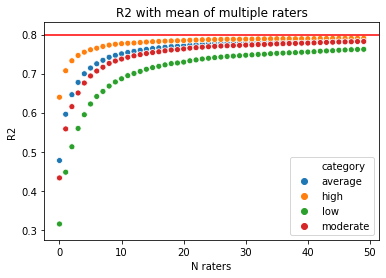

In [279]:
r2_mean = df_agg.groupby('category').apply(compute_r2).unstack().reset_index()
r2_mean.columns = ['N', 'category', 'r2']
ax = sns.scatterplot(x='N', y='r2', hue='category', data=r2_mean)
ax.axhline(true_r2, color='red')
ax.set_xlabel("N raters")
ax.set_ylabel("R2")
ax.set_title("R2 with mean of multiple raters");